In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

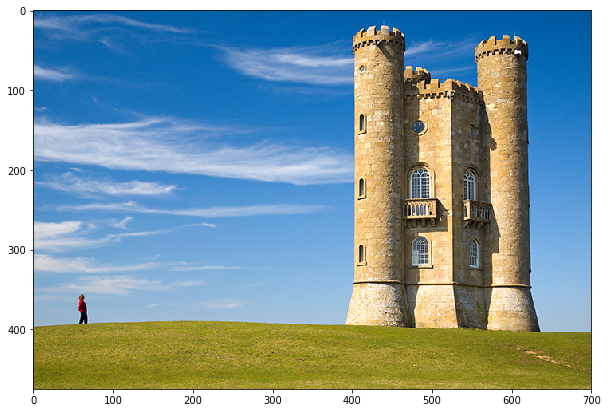

In [53]:
img = cv2.imread("public_data/01_input/img.png")
plt.figure(figsize=(10, 10))
plt.imshow(img[:,:,::-1]);

In [39]:
def energy(img):
    brightness = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)[:,:,0]
    derivative_x = np.vstack((brightness[1:2] - brightness[:1],
                              brightness[2:] - brightness[:-2],
                              brightness[-1:] - brightness[-2:-1]))
    derivative_y = np.hstack((brightness[:,1:2] - brightness[:,:1],
                              brightness[:,2:] - brightness[:,:-2],
                              brightness[:,-1:] - brightness[:,-2:-1]))
    return np.sqrt(derivative_x ** 2 + derivative_y ** 2)

def carve_seam(img, direction="horizontal"):
    if direction == "vertical":
        img = img.transpose(1, 0, 2)
    enrg = energy(img)
    cum = enrg.copy()
    for i in range(1, cum.shape[0]):
        for j in range(1, cum.shape[1] - 1):
            cum[i, j] += np.min(cum[i - 1, j - 1: j + 2])
        cum[i, 0] += np.min(cum[i - 1, :2])
        cum[i, -1] += np.min(cum[i - 1, -2:])
    
    # Build and carve seam simultaneously
    seam = np.zeros_like(cum, dtype=np.uint8)
    seam_y = np.argmin(cum[-1])
    seam[-1, seam_y] = 1
    img = list(img)
    img[-1] = np.concatenate((img[-1][:seam_y], img[-1][seam_y + 1:]), axis=0)
    for i in range(cum.shape[0] - 2, -1, -1):
        seam_y = np.argmin(cum[i, max(0, seam_y - 1): min(cum.shape[1], seam_y + 2)]) + max(0, seam_y - 1)
        seam[i, seam_y] = 1
        img[i] = np.concatenate((img[i][:seam_y], img[i][seam_y + 1:]), axis=0)
    
    img = np.array(img)
    if direction == "vertical":
        img = img.transpose(1, 0, 2)
    return img

In [47]:
from tqdm import tqdm

img_ = img.copy()
for _ in tqdm(range(300)):
    img_ = carve_seam(img_)

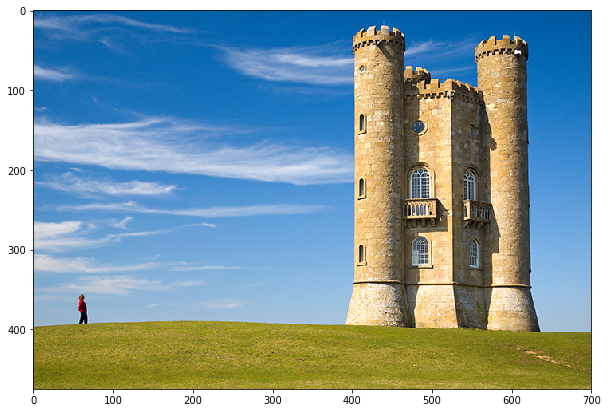

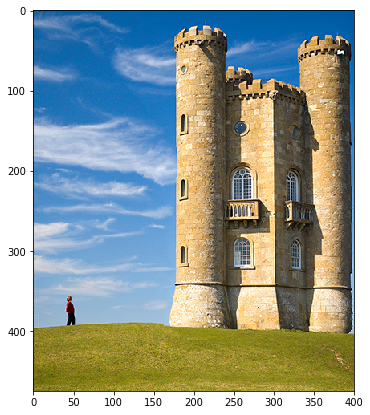

In [46]:
plt.figure(figsize=(10, 10))
plt.imshow(img[:,:,::-1])
plt.figure(figsize=(10, 7))
plt.imshow(img_[:,:,::-1])

---

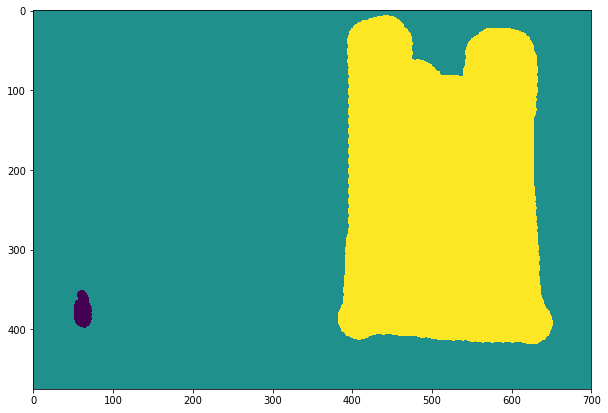

In [151]:
def convert_img_to_mask(img):
    return ((img[:, :, 0] != 0) * -1 + (img[:, :, 1] != 0)).astype('int8')

mask = cv2.imread("public_data/01_input/mask.png")
m = convert_img_to_mask(mask)
m = np.zeros_like(mask[:,:,0], dtype=np.int8)
m[np.where(mask[:,:,1])] = 1
m[np.where(mask[:,:,2])] = -1
plt.figure(figsize=(10, 10))
plt.imshow(m);

In [48]:
def energy(img):
    brightness = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)[:,:,0].astype(np.float32)
    derivative_x = np.vstack((brightness[1:2] - brightness[:1],
                              brightness[2:] - brightness[:-2],
                              brightness[-1:] - brightness[-2:-1]))
    derivative_y = np.hstack((brightness[:,1:2] - brightness[:,:1],
                              brightness[:,2:] - brightness[:,:-2],
                              brightness[:,-1:] - brightness[:,-2:-1]))
    return np.sqrt(derivative_x ** 2 + derivative_y ** 2)

In [120]:
def seam_carve(img, mode="horizontal shrink", mask=None):
    direction, action = mode.split()
    if direction == "vertical":
        img = img.transpose(1, 0, 2)
        mask = mask.transpose(1, 0)
    
    cum = energy(img)
    if mask is not None:
        delta = mask.shape[0] * mask.shape[1] * 256
        cum[mask == 1] += delta
        cum[mask == -1] -= delta
    for i in range(1, cum.shape[0]):
        for j in range(1, cum.shape[1] - 1):
            cum[i, j] += np.min(cum[i - 1, j - 1: j + 2])
        cum[i, 0] += np.min(cum[i - 1, :2])
        cum[i, -1] += np.min(cum[i - 1, -2:])
    
    # Build and carve seam simultaneously
    seam = []
    seam_y = np.argmin(cum[-1])
    img = list(img)
    if action == "shrink":
        img[-1] = np.concatenate((img[-1][:seam_y], img[-1][seam_y + 1:]), axis=0)
    else:
        img[-1] = np.concatenate((img[-1][:seam_y + 1],
                                 img[-1][seam_y: seam_y + 2].mean(axis=0).reshape(1, -1).astype(img[-1].dtype),
                                 img[-1][seam_y + 1:]),
                                axis=0)
    seam.append(np.zeros_like(img[-1][:,0], dtype=np.uint8))
    seam[-1][seam_y] = 1
        
    for i in range(cum.shape[0] - 2, -1, -1):
        seam_y = np.argmin(cum[i, max(0, seam_y - 1): min(cum.shape[1], seam_y + 2)]) + max(0, seam_y - 1)
        if action == "shrink":
            img[i] = np.concatenate((img[i][:seam_y],
                                     img[i][seam_y + 1:]),
                                    axis=0)
        else:
            img[i] = np.concatenate((img[i][:seam_y + 1],
                                     img[i][seam_y: seam_y + 2].mean(axis=0).reshape(1, -1).astype(img[-1].dtype),
                                     img[i][seam_y + 1:]),
                                    axis=0)
        seam.append(np.zeros_like(img[i][:,0], dtype=np.uint8))
        seam[-1][seam_y] = 1

    img = np.array(img)
    seam = np.array(seam[::-1])
        
    if direction == "vertical":
        img = img.transpose(1, 0, 2)
        mask = mask.transpose(1, 0)
        seam = seam.transpose(1, 0)

    return img, mask, seam

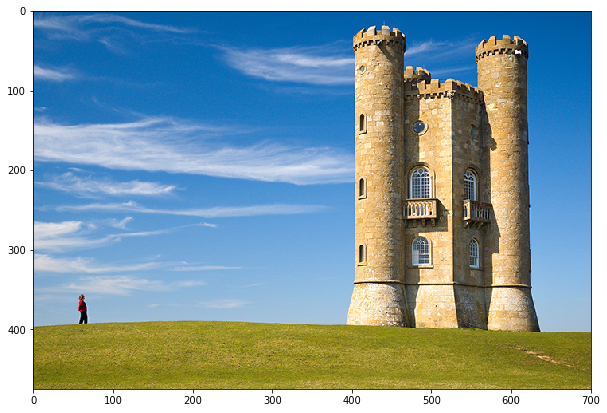

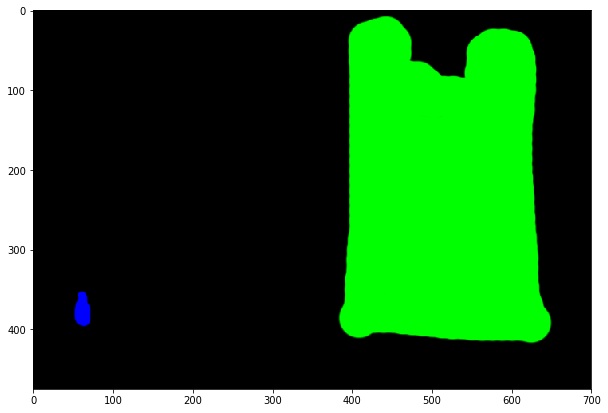

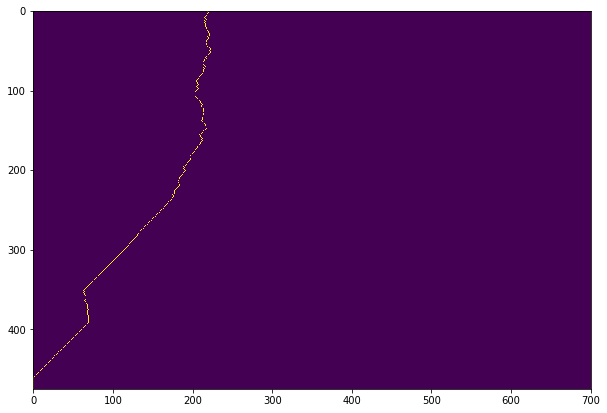

In [121]:
img_new, m_new, seam = seam_carve(img, "horizontal expand", m)
plt.figure(figsize=(10, 10))
plt.imshow(img_new[:,:,::-1])
plt.figure(figsize=(10, 10))
plt.imshow(mask)
plt.figure(figsize=(10, 10))
plt.imshow(seam);

In [127]:
from os.path import join
from pickle import load

with open(join('public_data/01_output', 'output_seams'), 'rb') as fout, \
     open(join('public_data/01_gt', 'seams'), 'rb') as fgt:
    for i in range(1):
        pred = load(fout)
        exp = load(fgt)

In [147]:
seam_pred = np.zeros_like(img, dtype=np.int8)
for ind in pred:
    seam_pred[ind + (1,)] = 1
for ind in exp:
    seam_pred[ind + (2,)] = 1
# seam_true = np.zeros_like(img[:,:,0])

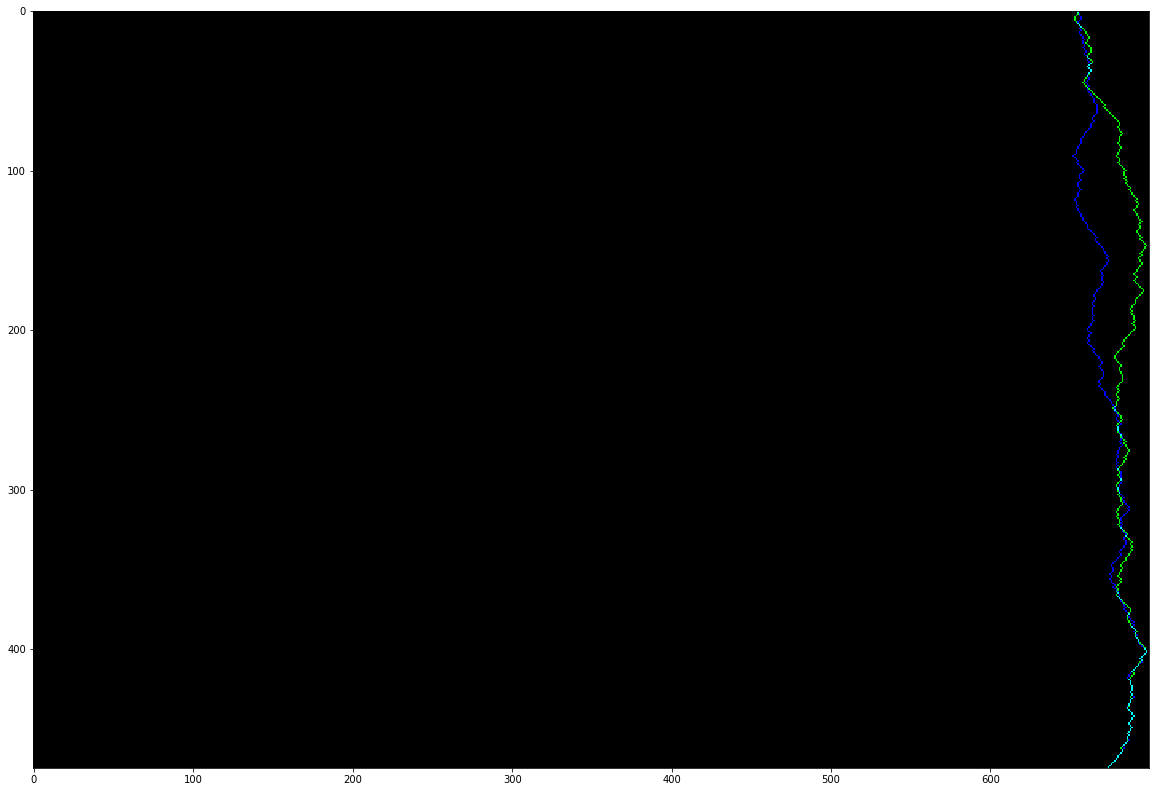

In [149]:
plt.figure(figsize=(20, 20))
plt.imshow(seam_pred);

In [150]:
for p in zip(pred, exp):
    print(p[0][1], p[1][1])

655 655
655 655
655 656
654 656
653 657
653 657
653 656
654 655
655 655
656 656
657 657
658 656
659 657
660 656
660 656
661 657
662 658
662 658
661 659
661 658
660 658
661 659
662 659
663 658
663 659
663 660
663 660
662 659
661 660
661 661
662 662
663 661
664 662
663 663
662 662
661 661
662 662
663 663
663 663
662 662
662 661
661 661
660 662
659 662
659 661
658 660
659 661
660 662
661 661
662 661
663 661
664 662
665 663
666 663
667 664
668 665
669 665
670 665
671 666
672 667
671 667
672 667
673 667
674 667
675 667
676 666
677 665
678 664
679 664
680 665
681 664
681 663
681 663
680 663
681 662
681 661
682 660
683 659
682 659
681 658
681 657
681 657
681 657
680 657
681 656
682 655
682 655
681 654
681 654
680 654
680 653
679 652
680 653
681 654
681 655
680 654
681 655
682 656
683 657
684 658
685 659
684 658
684 657
684 656
685 656
684 656
685 657
686 656
685 655
686 655
687 655
688 656
687 657
688 656
689 655
689 655
690 655
691 654
692 653
691 653
692 654
693 654
692 655
692 654
691 655
